# Тестовое задание в МШП
Менеджеры образовательной компании “Школа программистов” очень хотели начать принимать управленческие решения на основе данных.Поэтому, с целью сбора и хранения
данных была внедрена CRM-система “N-CRM”, отслеживающая всю
историю взаимодействия с учениками.

Основной метрикой в Школе программистов является
выбываемость с учебных курсов (отток учеников). Вам
необходимо помочь менеджерам Школы программистов
отслеживать данный показатель в различных разрезах (а в идеале
помочь найти в этих данных какие-то закономерности, которые
могли бы улучшить качество обучения).

Для выполнения этого задания IT-отдел компании
подготовил для Вас выгрузку из БД “N-CRM”. Эта выгрузка
является упрощенной моделью реальной БД с которой вам
предстоит работать.

Выгрузка состоит из 5 таблиц:
1. pupils - хранит данные об учениках
 * pupils.id - ID ученика
 * pupils.birth_year - год рождения ученика
2. courses - хранит данные об учебных курсах
 * courses.id - ID курса
 * courses.code - Учебный предмет
 * courses.date_from - Дата начала занятий на курсе
 * courses.date_till - Дата окончания занятий на курсе
 * courses.school_id - Школа, в которой проходят занятия по данному курсу
 * courses.teacher_id - Преподаватель, преподающий на курсе
3. pupils_courses - хранит данные о нахождении учеников на курсах
 * pupils_courses.id
 * pupils_courses.pupil_id - ID ученика
 * pupils_courses.course_id - ID курса
 * pupils_courses.date_from - Дата начала обучения ученика на курсе
 * pupils_courses.date_till - Дата окончания обучения ученика на курсе
4. teachers - хранит данные о преподавателях
 * teachers.id - ID преподавателя
 * teachers.age - Возраст преподавателя
5. schools - хранит данные об учебных центрах
 * school.id - ID учебного центра
 * school.name - Название учебного центра
 * school.city - Расположение учебного центра (регион)

Выбывшим c курса считается ученик, у которого дата окончания нахождения на курсе меньше, чем дата завершения самого курса. (`pupils_courses.date_till < courses.date_till`)

Для выполнения тестового задания Вам необходимо:
1. Разработать управленческий dashboard, с помощью которого менеджер сможет регулярно отслеживать выбываемость с курсов в динамике в различных разрезах (по предметам, по преподавателям, по отделениям итд - чем больше разрезов, тем лучше). Визуализация должна быть интерактивная. Желательно использовать инструменты для визуализации данных: Tableau/PowerBI/иные BI системы, Python.
2. Вывести топ-5 курсов по выбываемости.
3. Проверить гипотезу о том, что возраст преподавателя влияет на выбываемость учеников. Определить степень корреляции между возрастом преподавателя и выбываемостью.
4. Определить, какие ещё параметры влияют на выбываемость ученика с курса (возможно в компании “N” плохо работают с каким-то сегментом учеников? или методическое сопровождение какого-то предмета недостаточно и с него ученики выбывают больше обычного - в этом наборе данных много скрытых “инсайтов” :) )

Ссылка: https://docs.google.com/spreadsheets/d/1RcNnl4zUr1Vy6J34UP8ex4hQRhyNI7Pcq8grEgDZ4bc/edit#gid=0

In [5]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
from scipy import stats
from matplotlib import pyplot as plt

In [18]:
# читаем данные из файла xlsx

pupils = pd.read_excel('final_sample_data.xlsx', sheet_name='pupils')
courses = pd.read_excel('final_sample_data.xlsx', sheet_name='courses')
schools = pd.read_excel('final_sample_data.xlsx', sheet_name='schools')
pupils_courses = pd.read_excel('final_sample_data.xlsx', sheet_name='pupils_courses')
teachers = pd.read_excel('final_sample_data.xlsx', sheet_name='teachers')

## Задание №1
Разработать управленческий dashboard, с помощью которого менеджер сможет регулярно отслеживать выбываемость с курсов в динамике в различных разрезах (по предметам, по преподавателям, по отделениям итд - чем больше разрезов, тем лучше). Визуализация должна быть интерактивная. Желательно использовать инструменты для визуализации данных: Tableau/PowerBI/иные BI системы, Python.

In [19]:
# подготовим названия столбцов и форматы для объединения всех табличек

# приведем столбцы к формату даты
pupils_courses['date_from'] =  pd.to_datetime(pupils_courses['date_from'], format='%d.%m.%Y')
pupils_courses['date_till'] =  pd.to_datetime(pupils_courses['date_till'], format='%d.%m.%Y')
courses['date_till'] =  pd.to_datetime(courses['date_till'], format='%d.%m.%Y')
courses['date_from'] =  pd.to_datetime(courses['date_from'], format='%d.%m.%Y')

# переименуем столбцы в табличке с учениками, чтобы при объединении названия столбцов были уникальными (999 строчек)
pupils_courses = pupils_courses.rename(columns={'date_from':'ppl_date_from',
                                                'date_till':'ppl_date_till'}) 

# переименуем столбец в табличке с курсами, для того, чтобы появился курс, по которому будет мерж таблиц
courses = courses.rename(columns={'id':'course_id'}) 

# переименуем столбец для мерджа
teachers = teachers.rename(columns={'id':'teacher_id','age':'teacher_age'})
schools = schools.rename(columns={'id':'school_id','city':'school_region','name':'school_city'})
pupils = pupils.rename(columns={'id':'pupil_id','birth_date':'ppl_birth_date'})


In [20]:
# объединим все таблички в результирующую
df = pupils_courses\
    .merge(pupils, how='left', on='pupil_id')\
    .merge(courses, how='left', on='course_id')\
    .merge(teachers, how='left', on='teacher_id')\
    .merge(schools, how='left', on='school_id')

In [21]:
# поменяем столбцы местами для удобства чтения
df_new = df.reindex(columns=['id', 'pupil_id', 'ppl_birth_date','course_id','ppl_date_from','ppl_date_till',\
                             'subject','date_from','date_till','teacher_id','teacher_age','school_id','school_city',\
                            'school_region'])
df_new 

,id,pupil_id,ppl_birth_date,course_id,ppl_date_from,ppl_date_till,subject,date_from,date_till,teacher_id,teacher_age,school_id,school_city,school_region
0,1,72,2010,53,2017-01-01,2017-12-31,Python,2017-01-01,2017-12-31,9,42,1,Вологда,СЗФО
1,2,206,2012,87,2017-01-01,2017-12-31,WebDesign,2017-01-01,2017-12-31,4,23,6,Иваново,ЦФО
2,3,379,2005,28,2016-01-01,2016-03-05,Python,2016-01-01,2016-12-31,3,20,6,Иваново,ЦФО
3,4,285,2009,90,2017-01-01,2017-11-03,WebDesign,2017-01-01,2017-12-31,5,58,4,Владимир,ЦФО
4,5,5,2010,62,2017-01-01,2017-12-31,MachineLearning,2017-01-01,2017-12-31,10,19,2,Череповец,СЗФО
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,995,369,2007,9,2016-01-01,2016-12-31,WebDesign,2016-01-01,2016-12-31,1,35,6,Иваново,ЦФО
995,996,24,2009,25,2016-01-01,2016-12-31,C++,2016-01-01,2016-12-31,4,23,3,Брянск,ЦФО
996,997,296,2012,70,2017-01-01,2017-02-18,STEM,2017-01-01,2017-12-31,3,20,2,Череповец,СЗФО
997,998,198,2009,42,2017-01-01,2017-12-31,C++,2017-01-01,2017-12-31,8,40,1,Вологда,СЗФО


In [22]:
# поменяем тип данных на int для дальнейших рассчетов
df_new['ppl_birth_date'] = df_new['ppl_birth_date'].astype(str).astype(int)
df_new['teacher_age'] = df_new['teacher_age'].astype(str).astype(int)

In [23]:
# создадим новый столбец, принимающий значение 1 в случае, если ученик бросил курс
df_new ['abandoned'] = np.where(df_new.ppl_date_till < df_new.date_till, 1, 0)
df_new

,id,pupil_id,ppl_birth_date,course_id,ppl_date_from,ppl_date_till,subject,date_from,date_till,teacher_id,teacher_age,school_id,school_city,school_region,abandoned
0,1,72,2010,53,2017-01-01,2017-12-31,Python,2017-01-01,2017-12-31,9,42,1,Вологда,СЗФО,0
1,2,206,2012,87,2017-01-01,2017-12-31,WebDesign,2017-01-01,2017-12-31,4,23,6,Иваново,ЦФО,0
2,3,379,2005,28,2016-01-01,2016-03-05,Python,2016-01-01,2016-12-31,3,20,6,Иваново,ЦФО,1
3,4,285,2009,90,2017-01-01,2017-11-03,WebDesign,2017-01-01,2017-12-31,5,58,4,Владимир,ЦФО,1
4,5,5,2010,62,2017-01-01,2017-12-31,MachineLearning,2017-01-01,2017-12-31,10,19,2,Череповец,СЗФО,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,995,369,2007,9,2016-01-01,2016-12-31,WebDesign,2016-01-01,2016-12-31,1,35,6,Иваново,ЦФО,0
995,996,24,2009,25,2016-01-01,2016-12-31,C++,2016-01-01,2016-12-31,4,23,3,Брянск,ЦФО,0
996,997,296,2012,70,2017-01-01,2017-02-18,STEM,2017-01-01,2017-12-31,3,20,2,Череповец,СЗФО,1
997,998,198,2009,42,2017-01-01,2017-12-31,C++,2017-01-01,2017-12-31,8,40,1,Вологда,СЗФО,0


In [24]:
# сохраним в csv файл для дальнейшей работы с табле
df_new.to_excel('Files/mshp_test.xlsx', index=False)  

Дэшбоард доступен по ссылке: https://public.tableau.com/app/profile/egor2499/viz/mshp_dashborad/Dashboard1?publish=yes

## Задание №2
Вывести топ-5 курсов по выбываемости.

In [25]:
# сагрегируем данные по курсам
courses_churn = df_new\
    .groupby(['course_id','teacher_age'], as_index=False)\
    .agg({'pupil_id':'count', 'abandoned':'sum'})\
    .rename(columns={'pupil_id':'started'})

courses_churn

,course_id,teacher_age,started,abandoned
0,1,35,9,2
1,2,35,9,2
2,3,42,14,5
3,4,35,6,1
4,5,42,4,1
...,...,...,...,...
98,99,60,12,1
99,100,19,9,1
100,101,60,5,0
101,102,42,11,3


In [26]:
# создадим новую колонку churn_rate = кол-во ушедших за период/кол-во стартовавших * 100%
courses_churn['churn_rate'] = round(courses_churn.abandoned / courses_churn.started * 100,2)
courses_churn

,course_id,teacher_age,started,abandoned,churn_rate
0,1,35,9,2,22.22
1,2,35,9,2,22.22
2,3,42,14,5,35.71
3,4,35,6,1,16.67
4,5,42,4,1,25.00
...,...,...,...,...,...
98,99,60,12,1,8.33
99,100,19,9,1,11.11
100,101,60,5,0,0.00
101,102,42,11,3,27.27


In [27]:
# топ-5 курсов по выбыванию
courses_churn.sort_values('churn_rate', ascending=False).head(5)

,course_id,teacher_age,started,abandoned,churn_rate
29,30,60,15,9,60.00
71,72,24,10,5,50.00
18,19,42,10,5,50.00
85,86,40,15,7,46.67
11,12,42,11,5,45.45


## Задание №3
Проверить гипотезу о том, что возраст преподавателя влияет на выбываемость учеников. Определить степень корреляции между возрастом преподавателя и выбываемостью.

In [28]:
courses_churn = courses_churn.sort_values('teacher_age')
courses_churn

,course_id,teacher_age,started,abandoned,churn_rate
78,79,19,12,0,0.00
81,82,19,11,3,27.27
99,100,19,9,1,11.11
44,45,19,14,2,14.29
26,27,19,5,0,0.00
...,...,...,...,...,...
98,99,60,12,1,8.33
72,73,60,10,2,20.00
100,101,60,5,0,0.00
15,16,60,9,2,22.22


Text(0, 0.5, '% Выбываемости')

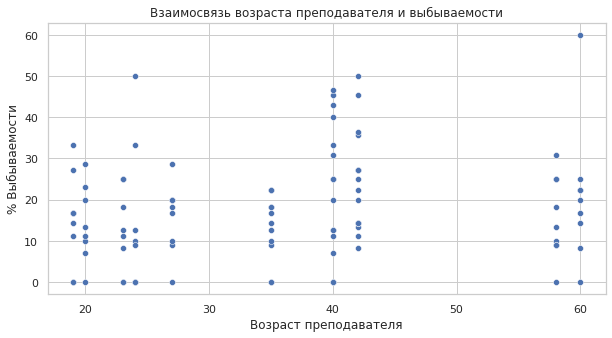

In [29]:
# визуализируем
sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)}) 
sns.scatterplot(x='teacher_age', y='churn_rate', data=courses_churn)
plt.title('Взаимосвязь возраста преподавателя и выбываемости')
plt.xlabel('Возраст преподавателя')
plt.ylabel('% Выбываемости')

### проверим данные по колонкам Возраст учителя и Отток по следующим параметрам
1. Связь линейна и монотонна (нарастает или убывает в одном направлении, не меняя его)
2. Отсутствуют выбросы
3. Переменные нормально распределены

In [30]:
stats.shapiro(courses_churn.teacher_age)

ShapiroResult(statistic=0.8881756663322449, pvalue=2.9611567242682213e-07)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


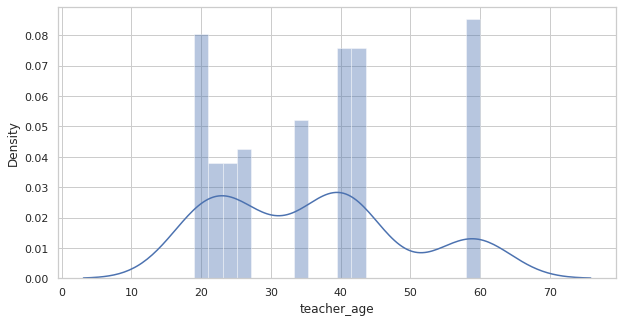

In [31]:
sns.distplot(courses_churn.teacher_age, bins=20)

In [32]:
stats.shapiro(courses_churn.churn_rate)

ShapiroResult(statistic=0.9374911785125732, pvalue=0.00010720938007580116)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


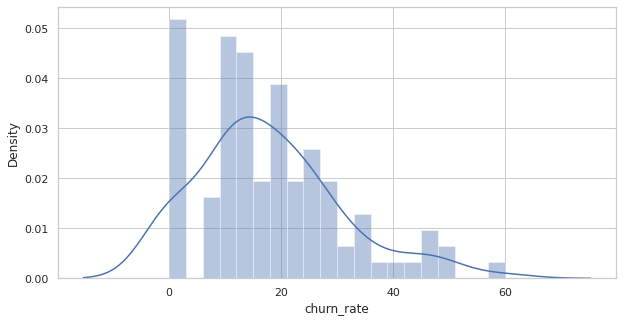

In [33]:
sns.distplot(courses_churn.churn_rate, bins=20)

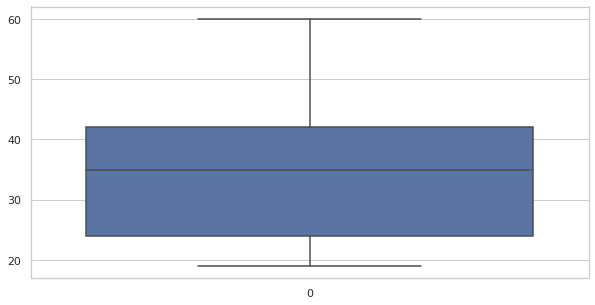

In [34]:
sns.boxplot(data=courses_churn.teacher_age)

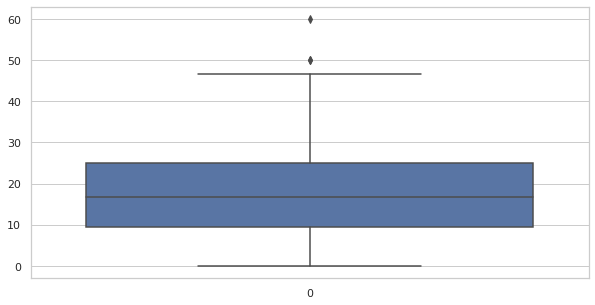

In [35]:
sns.boxplot(data=courses_churn.churn_rate)

In [36]:
# Итог: данные не распределены нормально, заметные выбросы есть в показаниях выбываемости, 
# следовательно для рассчета корреляции лучше использовать коэффицент корреляции Спирмана
st.spearmanr(courses_churn.teacher_age, courses_churn.churn_rate) 

SpearmanrResult(correlation=0.20331059484708763, pvalue=0.039421449187952186)

**Итого: p-уровень значимости < 0.05, следовательно существует положительная корреляция с коэф = 0.2**

## Задание №4
Определить, какие ещё параметры влияют на выбываемость ученика с курса (возможно в компании “N” плохо работают с каким-то сегментом учеников? или методическое сопровождение какого-то предмета недостаточно и с него ученики выбывают больше обычного - в этом наборе данных много скрытых “инсайтов” :) )

## 1. Проверим корреляцию между количество одновременно начатыми курсми и выбываемостью

In [37]:
# посчитаем какие ученики учатся на несколько курсах одновременно
df_amount_of_courses = df_new\
    .groupby(['pupil_id','ppl_date_from'], as_index=False)\
    .agg({'teacher_age':'count'})\
    .rename(columns={'teacher_age':'amount_of_courses'})

df_amount_of_courses

,pupil_id,ppl_date_from,amount_of_courses
0,1,2016-01-01,1
1,2,2016-01-01,1
2,2,2017-01-01,2
3,3,2017-01-01,2
4,4,2017-01-01,1
...,...,...,...
589,424,2016-01-01,5
590,425,2016-01-01,1
591,425,2017-01-01,1
592,426,2016-01-01,1


In [38]:
# смержим с основной таблицей
df_with_amount_new = df_new.merge(df_amount_of_courses, how='left', on=['pupil_id','ppl_date_from'])
df_with_amount_new

,id,pupil_id,ppl_birth_date,course_id,ppl_date_from,ppl_date_till,subject,date_from,date_till,teacher_id,teacher_age,school_id,school_city,school_region,abandoned,amount_of_courses
0,1,72,2010,53,2017-01-01,2017-12-31,Python,2017-01-01,2017-12-31,9,42,1,Вологда,СЗФО,0,3
1,2,206,2012,87,2017-01-01,2017-12-31,WebDesign,2017-01-01,2017-12-31,4,23,6,Иваново,ЦФО,0,6
2,3,379,2005,28,2016-01-01,2016-03-05,Python,2016-01-01,2016-12-31,3,20,6,Иваново,ЦФО,1,2
3,4,285,2009,90,2017-01-01,2017-11-03,WebDesign,2017-01-01,2017-12-31,5,58,4,Владимир,ЦФО,1,3
4,5,5,2010,62,2017-01-01,2017-12-31,MachineLearning,2017-01-01,2017-12-31,10,19,2,Череповец,СЗФО,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
994,995,369,2007,9,2016-01-01,2016-12-31,WebDesign,2016-01-01,2016-12-31,1,35,6,Иваново,ЦФО,0,1
995,996,24,2009,25,2016-01-01,2016-12-31,C++,2016-01-01,2016-12-31,4,23,3,Брянск,ЦФО,0,3
996,997,296,2012,70,2017-01-01,2017-02-18,STEM,2017-01-01,2017-12-31,3,20,2,Череповец,СЗФО,1,1
997,998,198,2009,42,2017-01-01,2017-12-31,C++,2017-01-01,2017-12-31,8,40,1,Вологда,СЗФО,0,3


In [39]:
# посчитаем выбываемость для параметра кол-во курсов
df_with_amount_new_churn = df_with_amount_new\
    .groupby(['amount_of_courses'], as_index=False)\
    .agg({'abandoned':'mean'})

df_with_amount_new_churn['abandoned'] = df_with_amount_new_churn['abandoned'] * 100
df_with_amount_new_churn

,amount_of_courses,abandoned
0,1,15.576324
1,2,19.060773
2,3,21.875000
3,4,14.473684
4,5,16.666667
5,6,22.222222


Text(0, 0.5, '% Выбываемости')

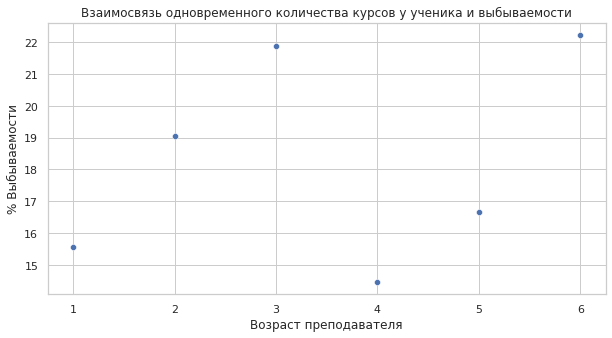

In [40]:
# визуализируем
sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)}) 
sns.scatterplot(x='amount_of_courses', y='abandoned', data=df_with_amount_new_churn)
plt.title('Взаимосвязь одновременного количества курсов у ученика и выбываемости')
plt.xlabel('Возраст преподавателя')
plt.ylabel('% Выбываемости')

**Вывод: корреляции не наблюдаеся**

### 2. На основе визуализации из табле можно сделать вывод о зависимости возраста, проверим статистически данную гипотезу
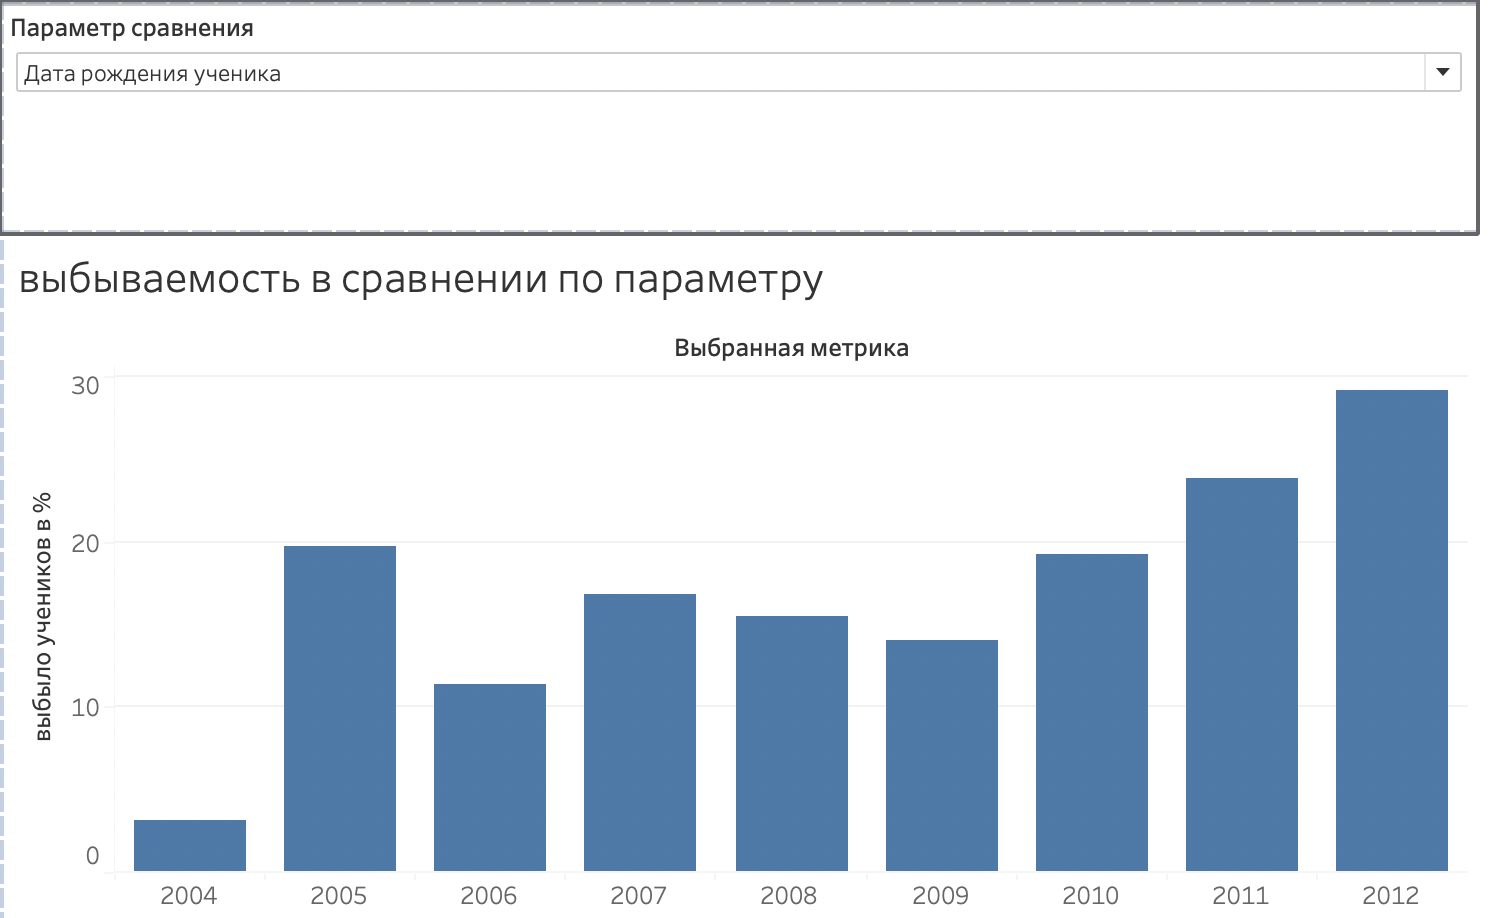

In [41]:
# посчитаем выбываемость для параметра год рождения ученика
df_churn_with_ppl_year = df_new\
    .groupby(['ppl_birth_date'], as_index=False)\
    .agg({'abandoned':'mean'})

df_churn_with_ppl_year['abandoned'] = df_churn_with_ppl_year['abandoned'] * 100
df_churn_with_ppl_year

,ppl_birth_date,abandoned
0,2004,3.125000
1,2005,19.736842
2,2006,11.428571
3,2007,16.814159
4,2008,15.483871
5,2009,14.044944
6,2010,19.310345
7,2011,23.931624
8,2012,29.203540


Text(0, 0.5, '% Выбываемости')

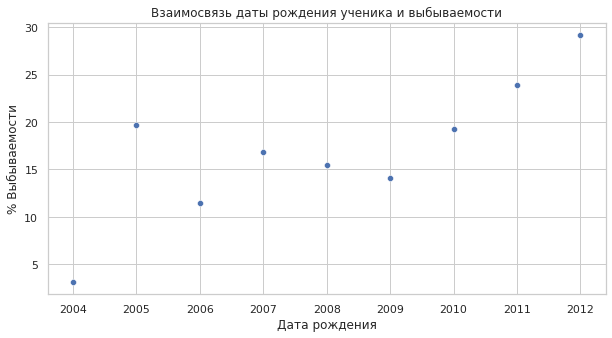

In [42]:
# визуализируем
sns.set(style='whitegrid', rc={'figure.figsize' : (10,5)}) 
sns.scatterplot(x='ppl_birth_date', y='abandoned', data=df_churn_with_ppl_year)
plt.title('Взаимосвязь даты рождения ученика и выбываемости')
plt.xlabel('Дата рождения')
plt.ylabel('% Выбываемости')

In [43]:
df_churn_with_ppl_year.dtypes

ppl_birth_date      int64
abandoned         float64
dtype: object

In [44]:
st.spearmanr(df_churn_with_ppl_year.ppl_birth_date, df_churn_with_ppl_year.abandoned) 

SpearmanrResult(correlation=0.6833333333333333, pvalue=0.04244227208707231)

**Итого: p-уровень значимости < 0.05, следовательно существует положительная корреляция с коэф = 0.68**

## 3. На основе графиков из tableau можно сделать гипотезы:
* В городе Череповец выбываемость превышает средний уровень
* В школе с id 2 выбываемость значительно превышает средний уровень
* У предмета webdesign повышенная выбываемость 
* У учителей с id 2,8,9 повышенная выбываемость

### Выведем курсы, у которых % выбываемости повышеает средний

In [45]:
# посчитаем выбываемость для параметра id курса
df_churn_with_coursed = df_new\
    .groupby(['course_id'], as_index=False)\
    .agg({'abandoned':'mean'})


df_churn_with_coursed['abandoned'] = df_churn_with_coursed['abandoned'] * 100
churn_cousr_rate = df_churn_with_coursed.abandoned.mean()

df_churn_with_coursed.query('abandoned > @ churn_cousr_rate')

,course_id,abandoned
0,1,22.222222
1,2,22.222222
2,3,35.714286
4,5,25.000000
5,6,23.076923
8,9,18.181818
9,10,33.333333
10,11,18.181818
11,12,45.454545
13,14,25.000000


## Для проверки выбываемости более узких сегментов на пересечении нескольких параметров и проверки выбросов предлагается воспользоваться фильтрами на представленном dashboard